In [ ]:
import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
from matplotlib.pyplot import plot, show
from seaborn import heatmap
from seaborn import barplot
import seaborn as sns
from tqdm import tqdm
import warnings
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
import json
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import dataframe_image as dfi
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# 导入数据并对数据进行整合与平整

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_dataset.csv', sep='\t')

In [3]:
train.shape

(15016, 19)

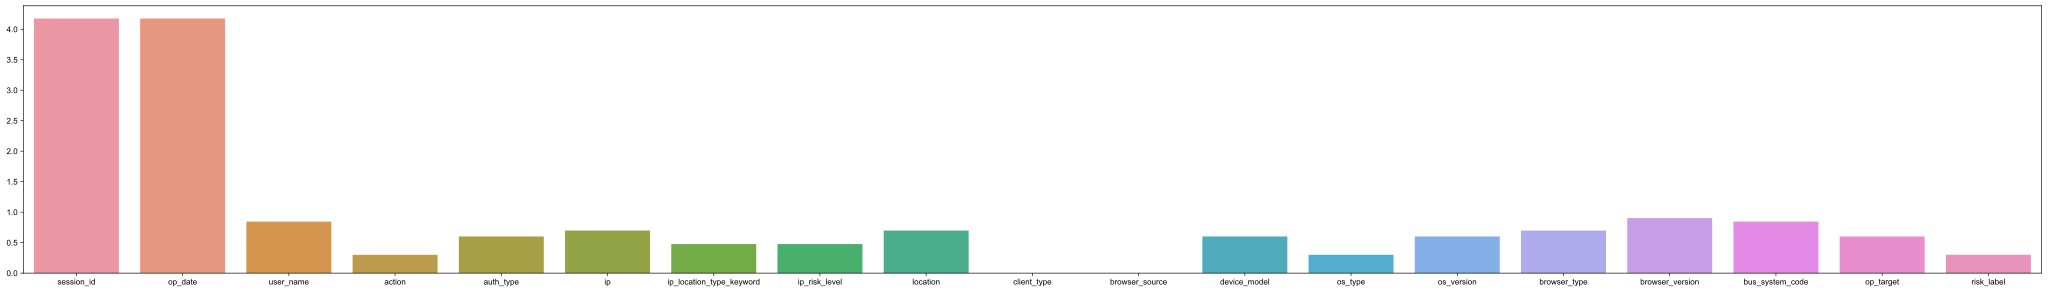

session_id                  15016
op_date                     15016
user_name                       7
action                          2
auth_type                       4
ip                              5
ip_location_type_keyword        3
ip_risk_level                   3
location                        5
client_type                     1
browser_source                  1
device_model                    4
os_type                         2
os_version                      4
browser_type                    5
browser_version                 8
bus_system_code                 7
op_target                       4
risk_label                      2
dtype: int64

In [4]:
uni = train.nunique()
fig1 = plt.figure(figsize=(45,6))
X = uni.index
Y = np.log10(uni)
bar = barplot(x=X,y=Y)
sns.set(style="white",font_scale=1.2)
plt.show()
bar.get_figure().savefig("uni_data.jpg",dpi = 800)
uni

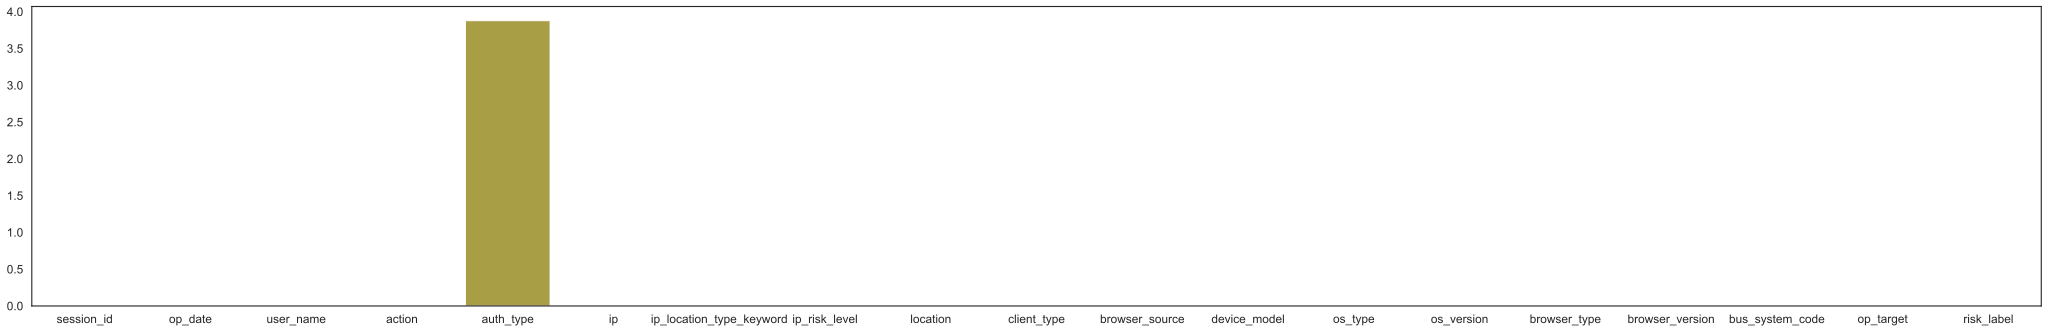

session_id                     0
op_date                        0
user_name                      0
action                         0
auth_type                   7535
ip                             0
ip_location_type_keyword       0
ip_risk_level                  0
location                       0
client_type                    0
browser_source                 0
device_model                   0
os_type                        0
os_version                     0
browser_type                   0
browser_version                0
bus_system_code                0
op_target                      0
risk_label                     0
dtype: int64

In [5]:
na = train.isna().sum()
fig2 = plt.figure(figsize=(40,6))
X = na.index
Y = np.log10(na[X])
bar = barplot(x=X,y=Y)
plt.show()
bar.get_figure().savefig("data.jpg",dpi = 800)
na

In [6]:
# 解决数据不平衡，采用上采样
ros = RandomOverSampler(random_state=0)
train, train['risk_label'] = ros.fit_resample(train, train['risk_label'])

test = pd.read_csv(DATA_PATH + 'test_dataset.csv', sep='\t')
data = pd.concat([train, test])
data

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,client_type,browser_source,device_model,os_type,os_version,browser_type,browser_version,bus_system_code,op_target,risk_label
0,access:test_d:20180101111639:bBp1,2018/1/1 11:16,test_d,login,otp,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,coremail,management,0.0
1,access:test_d:20180101121524:OBSg,2018/1/1 12:15,test_d,login,qr,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,order-mgnt,sales,0.0
2,access:test_d:20180101151333:BpQN,2018/1/1 15:13,test_d,login,qr,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,order-mgnt,sales,0.0
3,access:test_d:20180101124502:hYQm,2018/1/1 12:45,test_d,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,oa,management,0.0
4,access:test_d:20180101202749:FkDK,2018/1/1 20:27,test_d,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,order-mgnt,sales,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,access:test_a:20201231155549:fSaL,2020/12/31 15:55,test_a,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,oa,management,NaN
9996,access:test_a:20201231224950:uD7Y,2020/12/31 22:49,test_a,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,order-mgnt,sales,NaN
9997,access:test_a:20201231115831:TjRH,2020/12/31 11:58,test_a,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,crm,sales,NaN
9998,access:test_a:20201231193033:8VtL,2020/12/31 19:30,test_a,login,otp,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,order-mgnt,sales,NaN


# 细化特征

In [7]:
# 从session_id中读取秒数并存储
data['ii'] = data['session_id'].apply(lambda x: int(x[-7:-5]))

# 从location中读取其中三个属性并存储
data['location_first_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['first_lvl'])
data['location_sec_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['sec_lvl'])
data['location_third_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['third_lvl'])

data.drop(['client_type', 'browser_source'], axis=1, inplace=True)
data['auth_type'].fillna('1', inplace=True)


# 标签编码

In [8]:
# 对文本特征标签编码
for col in tqdm(['user_name', 'action', 'auth_type', 'ip',
                 'ip_location_type_keyword', 'ip_risk_level', 'location', 'device_model',
                 'os_type', 'os_version', 'browser_type', 'browser_version',
                 'bus_system_code', 'op_target', 'location_first_lvl', 'location_sec_lvl',
                 'location_third_lvl']):
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col])

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 239.38it/s]


# 细化时间特征

In [9]:
data['op_date'] = pd.to_datetime(data['op_date'])

# 获取操作具体时间
data['year'] = data['op_date'].dt.year
data['month'] = data['op_date'].dt.month
data['day'] = data['op_date'].dt.day
data['hour'] = data['op_date'].dt.hour

# 获取操作时间戳
data['op_ts'] = data["op_date"].values.astype(np.int64) // 10 ** 9

# 根据用户和操作时间戳排序，并计算每个用户的操作时间差
data = data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)
data['last_ts'] = data.groupby(['user_name'])['op_ts'].shift(1)
data['ts_diff'] = data['op_ts'] - data['last_ts']
data

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,device_model,...,location_first_lvl,location_sec_lvl,location_third_lvl,year,month,day,hour,op_ts,last_ts,ts_diff
0,access:test_a:20180107090803:WZc0,2018-01-07 09:08:00,0,0,1,2,1,0,3,1,...,1,1,3,2018,1,7,9,1515316080,NaN,NaN
1,access:test_a:20180107092734:9863,2018-01-07 09:27:00,0,0,2,2,1,0,3,1,...,1,1,3,2018,1,7,9,1515317220,1.515316e+09,1140.0
2,access:test_a:20180107093226:6qbJ,2018-01-07 09:32:00,0,0,3,2,1,0,3,1,...,1,1,3,2018,1,7,9,1515317520,1.515317e+09,300.0
3,access:test_a:20180107093834:QJrw,2018-01-07 09:38:00,0,1,0,2,1,0,3,1,...,1,1,3,2018,1,7,9,1515317880,1.515318e+09,360.0
4,access:test_a:20180107094058:vfu7,2018-01-07 09:40:00,0,0,1,2,1,0,3,1,...,1,1,3,2018,1,7,9,1515318000,1.515318e+09,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34147,access:test_g:20201224221351:iFaU,2020-12-24 22:13:00,6,0,2,2,1,0,3,1,...,1,1,3,2020,12,24,22,1608847980,1.608848e+09,420.0
34148,access:test_g:20201224223346:DG5Z,2020-12-24 22:33:00,6,1,0,2,1,0,3,1,...,1,1,3,2020,12,24,22,1608849180,1.608848e+09,1200.0
34149,access:test_g:20201224223945:ut2c,2020-12-24 22:39:00,6,1,0,2,1,0,3,1,...,1,1,3,2020,12,24,22,1608849540,1.608849e+09,360.0
34150,access:test_g:20201224225143:qBtz,2020-12-24 22:51:00,6,0,2,2,1,0,3,1,...,1,1,3,2020,12,24,22,1608850260,1.608850e+09,720.0


# 构建特征

In [10]:
# 特征构建
for f in ['ip', 'location', 'device_model', 'os_version', 'browser_version']:
    data[f'user_{f}_nunique'] = data.groupby(['user_name'])[f].transform('nunique')
for method in ['mean', 'max', 'min', 'std', 'sum', 'median']:
    for col in ['user_name', 'ip', 'location', 'device_model', 'os_version', 'browser_version']:
        data[f'ts_diff_{method}_' + str(col)] = data.groupby(col)['ts_diff'].transform(method)

group_list = ['user_name','ip', 'location', 'device_model', 'os_version', 'browser_version', 'op_target']
num_feature_list = ['ts_diff']
for group in group_list:
    for feature in num_feature_list:
        tmp = data.groupby(group)[feature].agg([sum, min, max, np.mean]).reset_index()
        tmp = pd.merge(data, tmp, on=group, how='left')
        data['{}-mean_gb_{}'.format(feature, group)] = data[feature] - tmp['mean']
        data['{}-min_gb_{}'.format(feature, group)] = data[feature] - tmp['min']
        data['{}-max_gb_{}'.format(feature, group)] = data[feature] - tmp['max']
        data['{}/sum_gb_{}'.format(feature, group)] = data[feature] / tmp['sum']

In [11]:
data

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,device_model,...,ts_diff-max_gb_os_version,ts_diff/sum_gb_os_version,ts_diff-mean_gb_browser_version,ts_diff-min_gb_browser_version,ts_diff-max_gb_browser_version,ts_diff/sum_gb_browser_version,ts_diff-mean_gb_op_target,ts_diff-min_gb_op_target,ts_diff-max_gb_op_target,ts_diff/sum_gb_op_target
0,access:test_a:20180107090803:WZc0,2018-01-07 09:08:00,0,0,1,2,1,0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,access:test_a:20180107092734:9863,2018-01-07 09:27:00,0,0,2,2,1,0,3,1,...,-21635760.0,2.182724e-06,-20294.664122,1140.0,-21635760.0,3.904624e-06,-10668.363292,1140.0,-8763900.0,3.044521e-05
2,access:test_a:20180107093226:6qbJ,2018-01-07 09:32:00,0,0,3,2,1,0,3,1,...,-21636600.0,5.744010e-07,-17027.839302,300.0,-14982900.0,1.302526e-06,-19205.050665,300.0,-21636600.0,8.706839e-07
3,access:test_a:20180107093834:QJrw,2018-01-07 09:38:00,0,1,0,2,1,0,3,1,...,-21636540.0,6.892812e-07,-21074.664122,360.0,-21636540.0,1.233039e-06,-11448.363292,360.0,-8764680.0,9.614275e-06
4,access:test_a:20180107094058:vfu7,2018-01-07 09:40:00,0,0,1,2,1,0,3,1,...,-21636780.0,2.297604e-07,-17207.839302,120.0,-14983080.0,5.210105e-07,-21520.770516,120.0,-22241760.0,5.449719e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34147,access:test_g:20201224221351:iFaU,2020-12-24 22:13:00,6,0,2,2,1,0,3,1,...,-21636480.0,8.041614e-07,-21014.664122,420.0,-21636480.0,1.438546e-06,-11388.363292,420.0,-8764620.0,1.121665e-05
34148,access:test_g:20201224223346:DG5Z,2020-12-24 22:33:00,6,1,0,2,1,0,3,1,...,-21635700.0,2.297604e-06,-16127.839302,1200.0,-14982000.0,5.210105e-06,-18305.050665,1200.0,-21635700.0,3.482736e-06
34149,access:test_g:20201224223945:ut2c,2020-12-24 22:39:00,6,1,0,2,1,0,3,1,...,-21636540.0,6.892812e-07,-21074.664122,360.0,-21636540.0,1.233039e-06,-19145.050665,360.0,-21636540.0,1.044821e-06
34150,access:test_g:20201224225143:qBtz,2020-12-24 22:51:00,6,0,2,2,1,0,3,1,...,-21636180.0,1.378562e-06,-20714.664122,720.0,-21636180.0,2.466078e-06,-18785.050665,720.0,-21636180.0,2.089641e-06


# 画出特征之间的协方差热力图

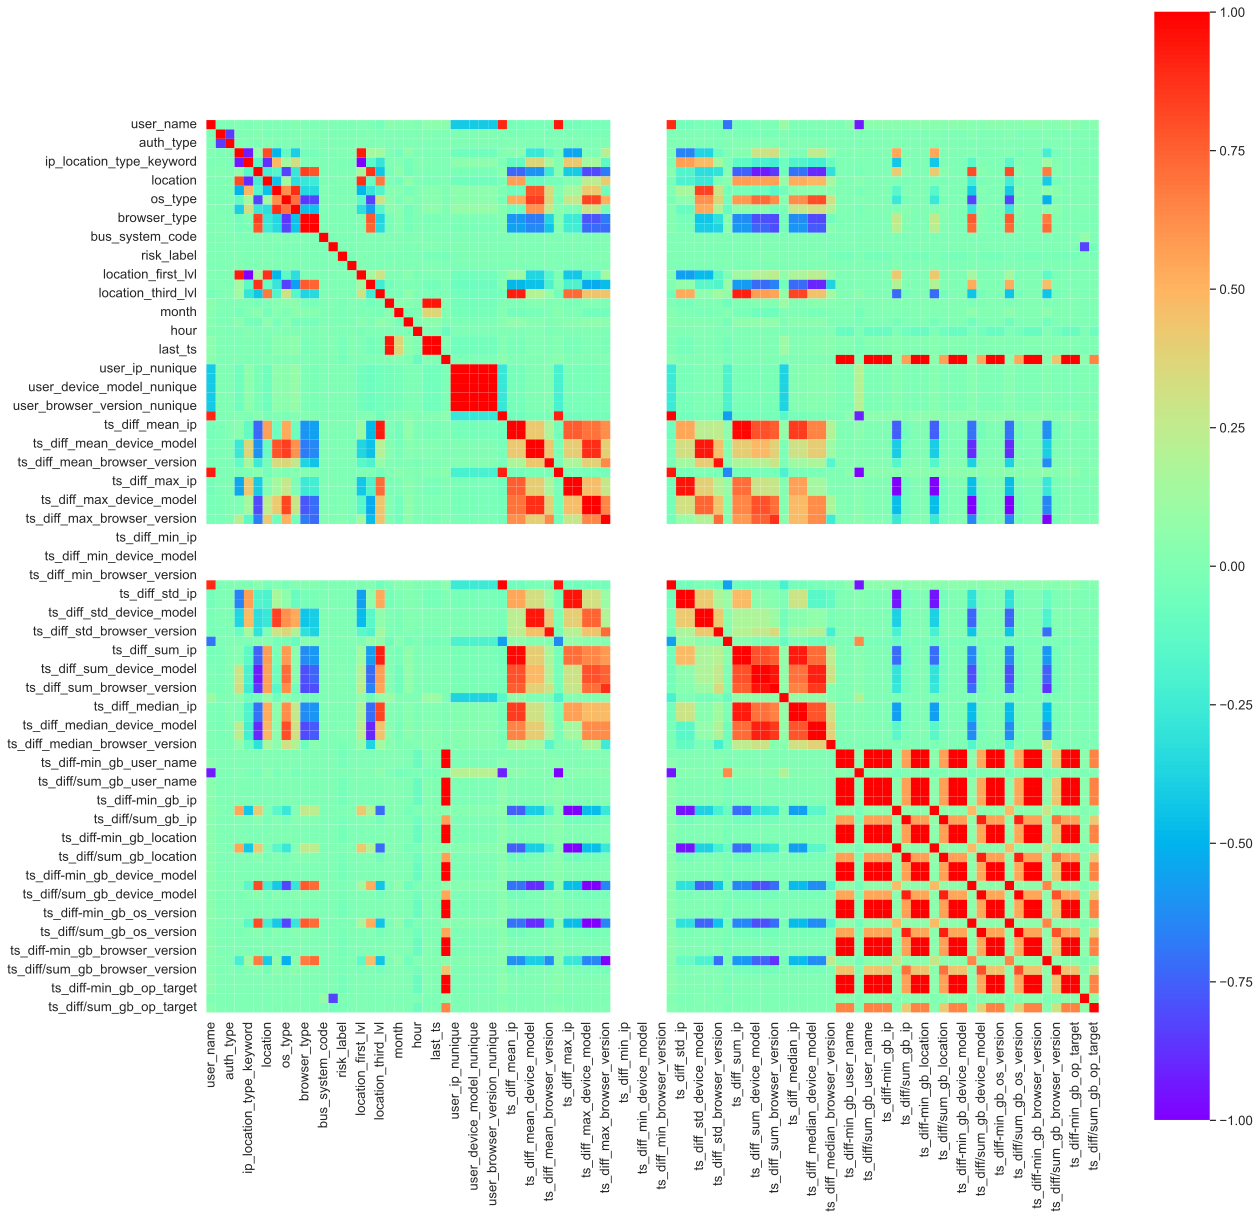

In [12]:
plt.figure(figsize=(20,20))
heat = heatmap(data.corr(), cmap='rainbow', square=True)
heat.get_figure().savefig("heat.jpg",dpi=1000)
plt.show()

# 分离训练集与测试集

In [13]:
train = data[~data['risk_label'].isna()].reset_index(drop=True)
test = data[data['risk_label'].isna()].reset_index(drop=True)
test

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,device_model,...,ts_diff-max_gb_os_version,ts_diff/sum_gb_os_version,ts_diff-mean_gb_browser_version,ts_diff-min_gb_browser_version,ts_diff-max_gb_browser_version,ts_diff/sum_gb_browser_version,ts_diff-mean_gb_op_target,ts_diff-min_gb_op_target,ts_diff-max_gb_op_target,ts_diff/sum_gb_op_target
0,access:test_a:20191106091046:QYmR,2019-11-06 09:10:00,0,0,3,2,1,0,3,1,...,-19440660.0,4.205075e-03,2.178912e+06,2196240.0,-12786960.0,9.535535e-03,2.184432e+06,2196240.0,-6568800.0,5.865349e-02
1,access:test_a:20191106092431:R2KP,2019-11-06 09:24:00,0,0,1,2,1,0,3,1,...,-21636060.0,1.608323e-06,-2.059466e+04,840.0,-21636060.0,2.877091e-06,-1.866505e+04,840.0,-21636060.0,2.437915e-06
2,access:test_a:20191106092853:TYxl,2019-11-06 09:28:00,0,1,0,2,1,0,3,1,...,-21636660.0,4.595208e-07,-2.119466e+04,240.0,-21636660.0,8.220260e-07,-1.926505e+04,240.0,-21636660.0,6.965471e-07
3,access:test_a:20191106095137:Ymdv,2019-11-06 09:51:00,0,1,0,2,1,0,3,1,...,-21635520.0,2.642245e-06,-1.594784e+04,1380.0,-14981820.0,5.991621e-06,-1.042836e+04,1380.0,-8763660.0,3.685472e-05
4,access:test_a:20191106100437:Jxwe,2019-11-06 10:04:00,0,1,0,2,1,0,3,1,...,-21636120.0,1.493443e-06,-1.654784e+04,780.0,-14982420.0,3.386568e-06,-1.872505e+04,780.0,-21636120.0,2.263778e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,access:test_g:20201224221351:iFaU,2020-12-24 22:13:00,6,0,2,2,1,0,3,1,...,-21636480.0,8.041614e-07,-2.101466e+04,420.0,-21636480.0,1.438546e-06,-1.138836e+04,420.0,-8764620.0,1.121665e-05
9996,access:test_g:20201224223346:DG5Z,2020-12-24 22:33:00,6,1,0,2,1,0,3,1,...,-21635700.0,2.297604e-06,-1.612784e+04,1200.0,-14982000.0,5.210105e-06,-1.830505e+04,1200.0,-21635700.0,3.482736e-06
9997,access:test_g:20201224223945:ut2c,2020-12-24 22:39:00,6,1,0,2,1,0,3,1,...,-21636540.0,6.892812e-07,-2.107466e+04,360.0,-21636540.0,1.233039e-06,-1.914505e+04,360.0,-21636540.0,1.044821e-06
9998,access:test_g:20201224225143:qBtz,2020-12-24 22:51:00,6,0,2,2,1,0,3,1,...,-21636180.0,1.378562e-06,-2.071466e+04,720.0,-21636180.0,2.466078e-06,-1.878505e+04,720.0,-21636180.0,2.089641e-06


In [14]:
train

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,device_model,...,ts_diff-max_gb_os_version,ts_diff/sum_gb_os_version,ts_diff-mean_gb_browser_version,ts_diff-min_gb_browser_version,ts_diff-max_gb_browser_version,ts_diff/sum_gb_browser_version,ts_diff-mean_gb_op_target,ts_diff-min_gb_op_target,ts_diff-max_gb_op_target,ts_diff/sum_gb_op_target
0,access:test_a:20180107090803:WZc0,2018-01-07 09:08:00,0,0,1,2,1,0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,access:test_a:20180107092734:9863,2018-01-07 09:27:00,0,0,2,2,1,0,3,1,...,-21635760.0,2.182724e-06,-20294.664122,1140.0,-21635760.0,3.904624e-06,-10668.363292,1140.0,-8763900.0,3.044521e-05
2,access:test_a:20180107093226:6qbJ,2018-01-07 09:32:00,0,0,3,2,1,0,3,1,...,-21636600.0,5.744010e-07,-17027.839302,300.0,-14982900.0,1.302526e-06,-19205.050665,300.0,-21636600.0,8.706839e-07
3,access:test_a:20180107093834:QJrw,2018-01-07 09:38:00,0,1,0,2,1,0,3,1,...,-21636540.0,6.892812e-07,-21074.664122,360.0,-21636540.0,1.233039e-06,-11448.363292,360.0,-8764680.0,9.614275e-06
4,access:test_a:20180107094058:vfu7,2018-01-07 09:40:00,0,0,1,2,1,0,3,1,...,-21636780.0,2.297604e-07,-17207.839302,120.0,-14983080.0,5.210105e-07,-21520.770516,120.0,-22241760.0,5.449719e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24147,access:test_g:20191007221944:HqFc,2019-10-07 22:19:00,6,0,4,4,0,2,4,0,...,-8502780.0,5.953285e-06,-13424.093914,360.0,-8502780.0,5.953285e-06,-19145.050665,360.0,-21636540.0,1.044821e-06
24148,access:test_g:20191007222958:lVHF,2019-10-07 22:29:00,6,1,0,4,0,2,4,0,...,-8502540.0,9.922141e-06,-13184.093914,600.0,-8502540.0,9.922141e-06,-21040.770516,600.0,-22241280.0,2.724859e-06
24149,access:test_g:20191007224449:oyX3,2019-10-07 22:44:00,6,1,0,4,0,2,4,0,...,-8502240.0,1.488321e-05,-12884.093914,900.0,-8502240.0,1.488321e-05,-18605.050665,900.0,-21636000.0,2.612052e-06
24150,access:test_g:20191007225230:MDr8,2019-10-07 22:52:00,6,0,4,4,0,2,4,0,...,-8502660.0,7.937713e-06,-13304.093914,480.0,-8502660.0,7.937713e-06,-19025.050665,480.0,-21636420.0,1.393094e-06


# 初始化与调参

In [15]:
# 挑选训练特征(session_id等特征均已经被缩放因此不再需要，risk_label作为目标标签)
features = [i for i in train.columns if i not in ['risk_label', 'session_id', 'op_date', 'last_ts']]
# 选出训练集中的目标标签
y = train['risk_label']

# 定义为5折验证
Fold = 5

# 挑选出分类特征
cat_cols = ['action', 'auth_type', 'browser_type',
            'browser_version', 'bus_system_code', 'device_model',
            'ip', 'ip_location_type_keyword', 'ip_risk_level', 'location', 'op_target',
            'os_type', 'os_version', 'user_name'
            ]

# 初始化n折交叉验证器
KF = StratifiedKFold(n_splits=Fold, random_state=2022, shuffle=True)

In [16]:
# 调参
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 5000,
    'max_bin': 255,
    'verbosity': -1,
    'seed': 2021,
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021,
    'early_stopping_rounds': 100,
}


# 使用n折交叉验证划分数据集（此处n取10）训练模型并进行预测

In [17]:
# 初始化预测值和oof
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros((len(test)))
importance = 0
# 采用n折交叉验证划分数据集，y为训练集中的目标标签risk_label,划分好的n-1折在训练集trn_idx,1折在验证集val_idx，均是去掉目标标签的训练集的一部分
for fold_, (trn_idx, val_idx) in enumerate(KF.split(train.values, y.values)):
    print("fold n°{}".format(fold_))
    # 获取用于训练的训练集和测试集，第一个参数为特征矩阵，第二个数参是对应标签，即训练集、验证集每个样本对应的risk_label
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=y.iloc[val_idx])
    num_round = 3000
    clf = lgb.train(
        params,
        trn_data,
        num_round,
        valid_sets=[trn_data, val_data],
        verbose_eval=100,
        early_stopping_rounds=50,
        categorical_feature=cat_cols
    )
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb[:] += clf.predict(test[features], num_iteration=clf.best_iteration) / Fold
    importance += clf.feature_importance(importance_type='gain') / Fold

fold n°0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.967104	valid_1's auc: 0.882172
Early stopping, best iteration is:
[14]	training's auc: 0.936125	valid_1's auc: 0.884316
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.969774	valid_1's auc: 0.883124
[200]	training's auc: 0.986786	valid_1's auc: 0.884006
[300]	training's auc: 0.995294	valid_1's auc: 0.885204
[400]	training's auc: 0.998197	valid_1's auc: 0.884866
Early stopping, best iteration is:
[337]	training's auc: 0.996681	valid_1's auc: 0.885256
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.965154	valid_1's auc: 0.878651
Early stopping, best iteration is:
[2]	training's auc: 0.910045	valid_1's auc: 0.88236
fold n°3
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.969651	valid_1's auc: 0.881459
Early stopping, best iteration is:
[29]	training's auc: 0.946443	

# 模型评测

In [18]:
print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))

AUC score: 0.8805189346241608


In [19]:
feats_importance = pd.DataFrame()
feats_importance['name'] = features
feats_importance['importance'] = importance
feats_importance.sort_values('importance', ascending=False)[:10]

,name,importance
23,ts_diff,75140.710110
66,ts_diff-min_gb_user_name,4800.154801
14,ii,1591.557074
22,op_ts,1300.536921
68,ts_diff/sum_gb_user_name,1259.156399
21,hour,868.040132
20,day,838.187780
65,ts_diff-mean_gb_user_name,779.722957
89,ts_diff-mean_gb_op_target,767.274667
92,ts_diff/sum_gb_op_target,745.082238


# 保存结果

In [20]:
test['ret'] = predictions_lgb
test['id'] = range(1, 10001)
test[['id', 'ret']].to_csv('ans/sub_5225.csv', index=False)
test['ret'].sum()

3239.9992665638274